## Bandit Simulation Study

In [66]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


Suppose we have 
$$X=UV^{T}$$
where $U \in \mathbb{R}^{NxK}$ and $V \in \mathbb{R}^{PxK}$
In each step, we want to choose an entry of $X$ to observe so that the average of the observed entries is as large as possible. We compare three methods: choosing the entries in descending order (the best solution), choosing the entries randomly, and choosing the entries using PCA.  

In [122]:
#Define Dimensions, K is true rank of matrix X, pcaK is rank of the matrix estimated by PCA,
#initialLength is the number of entries of X observed before the first iteration of PCA
N=10
P=8
K=1
pcaK=K
initialLength=int(np.ceil(0.2*np.sqrt(N*P)))

#Generate matrix X, whose entries should be positive
VectorOne=np.zeros((P,K))
for k in range(K):
    VectorOne[:,k]=np.random.multivariate_normal(3*np.ones(P), np.identity(P))
VectorTwo=np.zeros((N,K))
for k in range(K):
    VectorTwo[:,k]=np.random.multivariate_normal(3*np.ones(N), np.identity(N))
X=np.dot(VectorTwo, np.transpose(VectorOne))


#Calculate average rating in iteration i as (sum of entries observed after ith iteration)/(N*P)

#Best possible solution
sortX=np.asarray(list(reversed(np.sort(X, axis=None))))
bestCase=(1.0/(N*P))*np.cumsum(sortX)

#Choosing the entries to observe in random order 
R=20
np.random.shuffle(sortX)
randomCase=(1.0/(N*P))*np.cumsum(sortX)
for r in range(R-1):
    np.random.shuffle(sortX)
    randomCase += (1.0/(N*P))*np.cumsum(sortX)
randomCase=(1.0/R)*randomCase

Now we choose the entries using PCA. First we observe some number of entries of X randomly. Then we let $X_{i}$ be the matrix of all zeros except the entries that have been observed by iteration i. Using PCA we find $U_{i}$ and $V_{i}$ such that $X_{i}=U_{i}V_{i}^{T}$. We put a threshold on the number of components of $U_{i}$ and $V_{i}$, with this threshold we obtain an estimate of $X_{i}$ as $X_{i}'$. We choose our next entry to observe to be the largest unobserved entry of $X_{i}'$. 

In [123]:
#PCA Method
def PCArecommend(fn_components, observedX, index_list, ratings):
    observedX0=observedX-np.mean(observedX, axis=0)
    pca = PCA(n_components=fn_components)
    U=pca.fit_transform(observedX0)
    V=pca.components_
    Xsparsenew=np.dot(U,V)+np.mean(observedX, axis=0)
    index=np.argmax(Xsparsenew)
    dummyX=np.zeros((N,P))
    for n in range(N):
        for p in range(P):
            dummyX[n,p]=Xsparsenew[n,p]
    while np.any(index_list==index):
        dummyX[int(np.floor(index/P)), index-(P*int(np.floor(index/P)))]=-100
        index=np.argmax(dummyX)
    observedX[int(np.floor(index/P)), index-(P*int(np.floor(index/P)))]=X[int(np.floor(index/P)), index-(P*int(np.floor(index/P)))]
    ratings.append(X[int(np.floor(index/P)), index-(P*int(np.floor(index/P)))])
    index_list.append(index)
    return observedX, index_list, ratings

R = 20
pcaCase = np.zeros(N*P)
for i in range(R):
    #For PCA method, first observe some entries of X randomly
    randomlist1=random.choice(N,initialLength)
    randomlist2=random.choice(P,initialLength)
    observedX=np.zeros((N,P))
    index_list=np.empty([0]).tolist()
    ratings=np.empty([0]).tolist()
    for i in range(initialLength):
        observedX[randomlist1[i], randomlist2[i]]=X[randomlist1[i], randomlist2[i]]
        index_list.append(int(P*randomlist1[i]+randomlist2[i]))
        ratings.append(X[randomlist1[i], randomlist2[i]])
    
    #PCA Method
    while np.asarray(index_list).size < N*P:
        observedX, index_list, ratings=PCArecommend(pcaK, observedX, index_list, ratings)

    pcaCase += (1.0/(N*P))*np.cumsum(np.asarray(ratings))
    
pcaCase = pcaCase/R

## Nuclear norm minimisation

The function below does matrix completion through nuclear norm minimisation, using the package 'cvxpy'. It solves the following problem:

$$\text{Minimise } \|S\| $$
$$\text{such that } |S_{ij}-X_{ij}|\leq \epsilon \text{ for all } X_{ij} \text{ observed}.$$

Here, $\epsilon$ is an error tolerance --- the higher $\epsilon$, the smaller the nuclear norm of the solution. This tuning parameter could be adjusted to optimise the performance of the bandit algorithm.

In [124]:
from __future__ import absolute_import, print_function, division
import cvxpy

class NuclearNormMinimization:
    """
    Simple implementation of "Exact Matrix Completion via Convex Optimization"
    by Emmanuel Candes and Benjamin Recht using cvxpy.
    """

    def __init__(
            self,
            require_symmetric_solution=False,
            min_value=None,
            max_value=None,
            error_tolerance=0.0001,
            fast_but_approximate=True,
            verbose=True):
        """
        Parameters
        ----------
        require_symmetric_solution : bool
            Add symmetry constraint to convex problem
        min_value : float
            Smallest possible imputed value
        max_value : float
            Largest possible imputed value
        error_tolerance : bool
            Degree of error allowed on reconstructed values. If omitted then
            defaults to 0.0001
        fast_but_approximate : bool
            Use the faster but less accurate Splitting Cone Solver
        verbose : bool
            Print debug info
        """
        self.min_value=min_value
        self.max_value=max_value
        self.require_symmetric_solution = require_symmetric_solution
        self.error_tolerance = error_tolerance
        self.fast_but_approximate = fast_but_approximate
        self.verbose = verbose

    def _constraints(self, X, missing_mask, S, error_tolerance):
        """
        Parameters
        ----------
        X : np.array
            Data matrix with missing values filled in
        missing_mask : np.array
            Boolean array indicating where missing values were
        S : cvxpy.Variable
            Representation of solution variable
        """
        ok_mask = ~missing_mask
        masked_X = cvxpy.mul_elemwise(ok_mask, X)
        masked_S = cvxpy.mul_elemwise(ok_mask, S)
        abs_diff = cvxpy.abs(masked_S - masked_X)
        close_to_data = abs_diff <= error_tolerance
        constraints = [close_to_data]
        if self.require_symmetric_solution:
            constraints.append(S == S.T)

        if self.min_value is not None:
            constraints.append(S >= self.min_value)

        if self.max_value is not None:
            constraints.append(S <= self.max_value)

        return constraints

    def _create_objective(self, m, n):
        """
        Parameters
        ----------
        m, n : int
            Dimensions that of solution matrix
        Returns the objective function and a variable representing the
        solution to the convex optimization problem.
        """
        # S is the completed matrix
        S = cvxpy.Variable(m, n, name="S")
        norm = cvxpy.norm(S, "nuc")
        objective = cvxpy.Minimize(norm)
        return S, objective

    def solve(self, X, missing_mask):
        m, n = X.shape
        S, objective = self._create_objective(m, n)
        constraints = self._constraints(
            X=X,
            missing_mask=missing_mask,
            S=S,
            error_tolerance=self.error_tolerance)
        problem = cvxpy.Problem(objective, constraints)
        #print(problem)
        problem.solve(
            verbose=self.verbose,
            # SCS solver is known to be faster but less exact
            solver=cvxpy.SCS if self.fast_but_approximate else None)
        return S.value
    

In [125]:
def NNrecommend(observedX, index_list, ratings):
    solver = NuclearNormMinimization(min_value=-20,max_value=20,verbose=False,error_tolerance=0.3)
    unobservedMask = np.isnan(observedX) 
    Xsparsenew = solver.solve(np.nan_to_num(observedX),unobservedMask)
    Xsparsenew[~unobservedMask] = -inf
    index=np.argmax(Xsparsenew)
    i,j = int(np.floor(index/P)), index-(P*int(np.floor(index/P)))
    observedX[i,j]=X[i,j]
    ratings.append(X[i,j])
    index_list.append(index)
    return observedX, index_list, ratings

R=20
nnCase = np.zeros(N*P)
for i in range(R):

    #For NN method, first observe some entries of X randomly
    randomlist1=random.choice(N,initialLength)
    randomlist2=random.choice(P,initialLength)
    observedX=np.zeros((N,P))
    observedX[:,:] = nan
    index_list=np.empty([0]).tolist()
    ratings=np.empty([0]).tolist()
    for i in range(initialLength):
        observedX[randomlist1[i], randomlist2[i]]=X[randomlist1[i], randomlist2[i]]
        index_list.append(int(P*randomlist1[i]+randomlist2[i]))
        ratings.append(X[randomlist1[i], randomlist2[i]])
    
    #NN Method
    while np.asarray(index_list).size < N*P:
        observedX, index_list, ratings=NNrecommend(observedX, index_list, ratings)

    nnCase += (1.0/(N*P))*np.cumsum(np.asarray(ratings))
nnCase = nnCase/R

### Plots

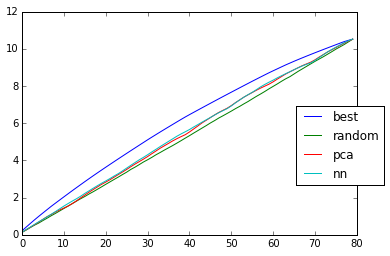

In [126]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.plot(bestCase, label='best')
ax.plot(randomCase, label='random')
ax.plot(pcaCase, label='pca')
ax.plot(nnCase, label='nn')
ax.legend(loc='center left', bbox_to_anchor=(0.8, 0.4))